In [2]:
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore
from tensorflow import keras

In [3]:
# Constants
# batch size for model
BATCH_SIZE = 100
# number of epochs
EPOCHS = 20
# proportion of validation data
VALIDATION_SPLIT = 0.2
# learning rate and epsilon for ADAM optimizer
LEARNING_RATE = 0.01
EPSILON = 1
# path where data is stored
PATH="/Users/tanvipotdar/Projects/thesis/data/INTC_2015-01-01_2015-01-31_10"
# prediction horizon
K = 50 
# threshold to decide which category midprice direction falls in (up, down, stationary)
ALPHA = 0.001

# Static objects
# instantiate one hot encoder here so that all classes will always map to the same labels
onehot_encoder = OneHotEncoder(sparse=False)

### Prepare the data

In [4]:
def get_data(path, num_files_to_choose=np.inf):
    all_files = glob.glob(path + "/*orderbook_10.csv")
    all_files.sort()
    i = min(num_files_to_choose, len(all_files))
    orderbooks = []
    for filename in all_files[:i]:
        df = pd.read_csv(filename, index_col=None, header=None)
        orderbooks.append(df)
    orderbook = pd.concat(orderbooks, axis=0, ignore_index=True)
    col_names = ['ask_price_', 'ask_size_', 'bid_price_', 'bid_size_']
    nums = map(str, range(1,11))
    orderbook.columns = [y + x for x in nums for y in col_names]
    return orderbook
data = get_data(path=PATH, num_files_to_choose=3)
data.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,367300,4000,365200,400,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
1,367300,4000,365200,400,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
2,367300,4000,365200,100,367500,200,364800,300,367900,300,...,361800,200,372900,1000,361500,200,373400,2500,360800,200
3,367300,4000,365200,100,367500,200,364800,300,367900,300,...,362900,200,372900,1000,361800,200,373400,2500,361500,200
4,367300,4000,365200,100,367500,200,364800,300,367900,300,...,362900,200,372900,1000,361800,200,373400,2500,361500,200


In [5]:
def normalise_data(data):
    normalised_data = data.apply(zscore)
    return normalised_data
normalised_data = normalise_data(data)
normalised_data.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,1.641743,-0.076267,1.171577,-0.753204,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.529661,-0.579836,2.781734,-0.951862,0.482117,-0.62744,2.876673,-0.219309,0.339465,-0.559228
1,1.641743,-0.076267,1.171577,-0.753204,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.529661,-0.579836,2.781734,-0.951862,0.482117,-0.62744,2.876673,-0.219309,0.339465,-0.559228
2,1.641743,-0.076267,1.171577,-0.813901,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.529661,-0.579836,2.781734,-0.951862,0.482117,-0.62744,2.876673,-0.219309,0.339465,-0.559228
3,1.641743,-0.076267,1.171577,-0.813901,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.791232,-0.579836,2.781734,-0.951862,0.553455,-0.62744,2.876673,-0.219309,0.505915,-0.559228
4,1.641743,-0.076267,1.171577,-0.813901,1.665477,-1.888278,1.100263,-0.914844,1.736729,-1.84804,...,0.791232,-0.579836,2.781734,-0.951862,0.553455,-0.62744,2.876673,-0.219309,0.505915,-0.559228


In [6]:
# smoothed labelling of the midprice/ K is the prediction horizon
def smooth_midprice_using_k_lookahead(normalised_data, k):
    normalised_data['midprice'] = (normalised_data.ask_price_1+normalised_data.bid_price_1)/2
    # mean of previous k mid-prices
    normalised_data['m_minus'] = normalised_data['midprice'].rolling(window=k).mean()
    # mean of next k mid-prices
    normalised_data['m_plus'] = normalised_data['midprice'][::-1].rolling(window=k).mean()[::-1]
    return normalised_data
normalised_data = smooth_midprice_using_k_lookahead(normalised_data, k=K)

In [7]:
# label the smoothed mid-prices based on a threshold/ ALPHA is the threshold 
def create_midprice_labels(normalised_data):
    normalised_data['change'] = (normalised_data.m_plus - normalised_data.m_minus)/normalised_data.m_minus
    # assign categories up, down, stationary
    normalised_data['label'] = pd.cut(normalised_data.change, bins=[-np.inf, -ALPHA, ALPHA, np.inf], 
                                    labels=['down', 'stationary', 'up'])
    # drop all unlabelled values (will be first and last k values as they have no m_minus/m_plus value)
    normalised_data.dropna(inplace=True)
    return normalised_data
normalised_data = create_midprice_labels(normalised_data)

In [8]:
# split into train and test data
N = len(normalised_data) - len(normalised_data)%100
def reshape_and_categorise_data(normalised_data, n):
    data = normalised_data[:n]
    cols = data.columns.to_list()[:40]
    input_data = data[cols]
    input_array = input_data.to_numpy().reshape(n//100,100,40,1)

    output_data = data.label.to_numpy()[::-100][::-1]
    integer_encoded = output_data.reshape(len(output_data), 1)
    output_array = onehot_encoder.fit_transform(integer_encoded)
    X_train, X_test, y_train, y_test = train_test_split(input_array, output_array, shuffle=False)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = reshape_and_categorise_data(normalised_data, N)
print("Training input shape:",X_train.shape)
print("Test input shape:", X_test.shape)
print("Training output shape:", y_train.shape)
print("Test input shape:", y_test.shape)

Training input shape: (23017, 100, 40, 1)
Test input shape: (7673, 100, 40, 1)
Training output shape: (23017, 3)
Test input shape: (7673, 3)


In [9]:
# mapping of labels to one hot encoding
print(onehot_encoder.inverse_transform([[1,0,0],[0,0,1],[0,1,0]]))
# Using np.argmax equates: 0-down, 1-stationary, 2-up

[['down']
 ['up']
 ['stationary']]


### Build and compile the model

In [10]:
def create_model():
    # convolutional layers
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,2), input_shape=(100,40,1), strides=(1, 2)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,2), strides=(1, 2)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,10), input_shape=(100,10,1)))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(4,1)))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(4,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(3,1)))
    model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))

    # lstm layer
    model.add(keras.layers.SimpleRNN(100))
    model.add(keras.layers.Dense(3,activation='softmax'))
    # compile model and summarize
    adam = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
model = create_model()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 20, 16)       48        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 20, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 20, 16)        1040      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 20, 16)        1040      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 10, 16)        528       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 94, 10, 16)        0         
_________________________________________________________________
conv

In [11]:
def fit_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)
    score, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print("Accuracy is {}%".format(accuracy*100))
    return accuracy*100, history
accuracy, history = fit_and_evaluate_model(model, X_train, X_test, y_train, y_test)

Train on 18413 samples, validate on 4604 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
18413/18413 [==============================] - 69s 4ms/sample - loss: 1.0167 - acc: 0.5252 - val_loss: 1.1311 - val_acc: 0.2937
Epoch 2/20
18413/18413 [==============================] - 70s 4ms/sample - loss: 0.9448 - acc: 0.5722 - val_loss: 1.4125 - val_acc: 0.2174
Epoch 3/20
18413/18413 [==============================] - 72s 4ms/sample - loss: 0.9077 - acc: 0.5744 - val_loss: 1.4456 - val_acc: 0.2018
Epoch 4/20
18413/18413 [==============================] - 68s 4ms/sample - loss: 0.8841 - acc: 0.5908 - val_loss: 1.3052 - val_acc: 0.2813
Epoch 5/20
18413/18413 [==============================] - 67s 4ms/sample - loss: 0.8640 - acc: 0.6043 - val_loss: 1.4194 - val_acc: 0.2398
Epoch 6/20
18413/18413 [==============================] - 59s 3ms/sample - loss: 0.8467 - acc: 0.6210 - val_loss: 1.4015 - val_acc: 0.2370
Epoch 7/20
18413/18413 [==============================] - 41s 2ms/sam

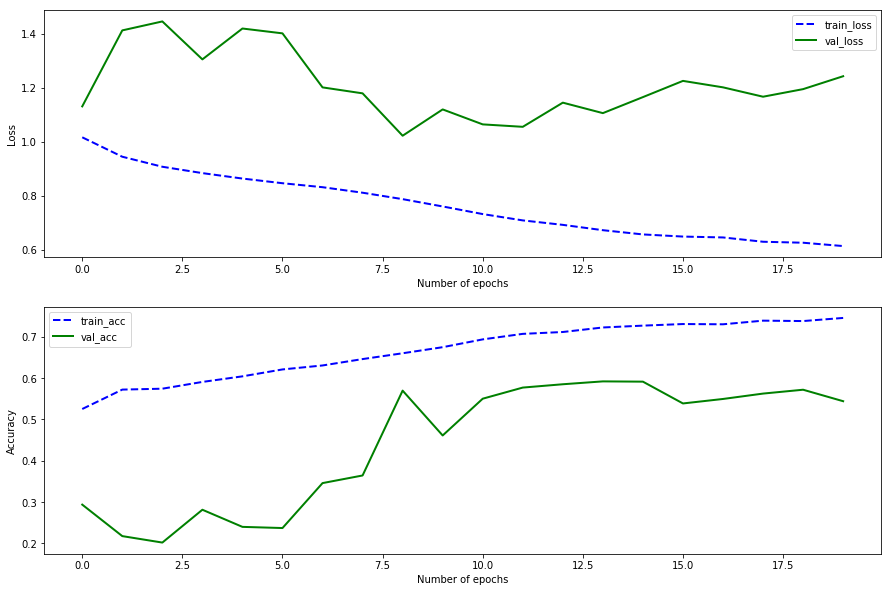

In [12]:
def plots(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
    plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
    plt.legend()
    # plt.ylim([.5,1.3])
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.subplot(2,1,2)
    plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
    plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
    plt.legend()
    # plt.ylim([.2,1.0])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.show()
plots(history)

### Evaluate performance

In [13]:
def get_report(model, X_test, y_test, X_train, y_train):
    target_names = ['down', 'stationary', 'up']
    y_pred = model.predict(X_test)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_test_bool = np.argmax(y_test, axis=1)
    print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
    print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))
get_report(model, X_test, y_test, X_train, y_train)

              precision    recall  f1-score   support

        down       0.01      0.04      0.02       502
  stationary       0.85      0.72      0.78      5294
          up       0.09      0.08      0.09      1877

   micro avg       0.52      0.52      0.52      7673
   macro avg       0.32      0.28      0.30      7673
weighted avg       0.61      0.52      0.56      7673

[[  20  412 1080]
 [  25 3804  640]
 [ 457 1078  157]]
